<a href="https://colab.research.google.com/github/DEEPAK-RAMGIRI/AIML-LAB/blob/main/website_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.preprocessing import StandardScaler

In [14]:
df = pd.read_csv('website_classification.csv')

In [15]:
df.head(5)

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [16]:
nltk.download('stopwords') # to use nltk stopwords we need to download the stopwords
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:
df.columns

Index(['Unnamed: 0', 'website_url', 'cleaned_website_text', 'Category'], dtype='object')

In [18]:
df.dtypes

,0
Unnamed: 0,int64
website_url,object
cleaned_website_text,object
Category,object


In [19]:
df = df.drop(["Unnamed: 0", "website_url"], axis=1)

In [20]:
pd.DataFrame(df.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

In [21]:
def clean_text(text):
    tokens = word_tokenize(text.lower())
    words = [re.sub(r'[^a-z]', '', word) for word in tokens]
    stop_words = set(stopwords.words('english'))
    filtered = [w for w in words if w and w not in stop_words]
    return ' '.join(filtered)

In [24]:
df['cleaned_website_text'] = df['cleaned_website_text'].apply(clean_text)

In [25]:
label_encoder = LabelEncoder()
df['category_id'] = label_encoder.fit_transform(df['Category'])
num_classes = len(label_encoder.classes_)

In [26]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['cleaned_website_text']).toarray()

In [38]:
  scaler = StandardScaler()
  X = scaler.fit_transform(X)

In [39]:
y_encoded = df['category_id'].values.reshape(-1, 1)
one_hot_encoder = OneHotEncoder(sparse_output=False)
y = one_hot_encoder.fit_transform(y_encoded)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.callbacks import EarlyStopping


Training with SGD optimizer...

Training with SGD+Momentum optimizer...

Training with RMSprop optimizer...

Training with Adam optimizer...

Training with Adagrad optimizer...

=== Optimizer Comparison ===
      Optimizer  Train Loss  Train Acc  Test Loss  Test Acc
0           SGD      0.2696    99.2893     2.2572     66.19
1  SGD+Momentum      0.0225    99.6954     1.6921     81.56
2       RMSprop      0.1234    97.4619     1.3877     79.43
3          Adam      0.0344    99.2893     2.7190     80.61
4       Adagrad      0.4066    99.5939     1.9345     67.85


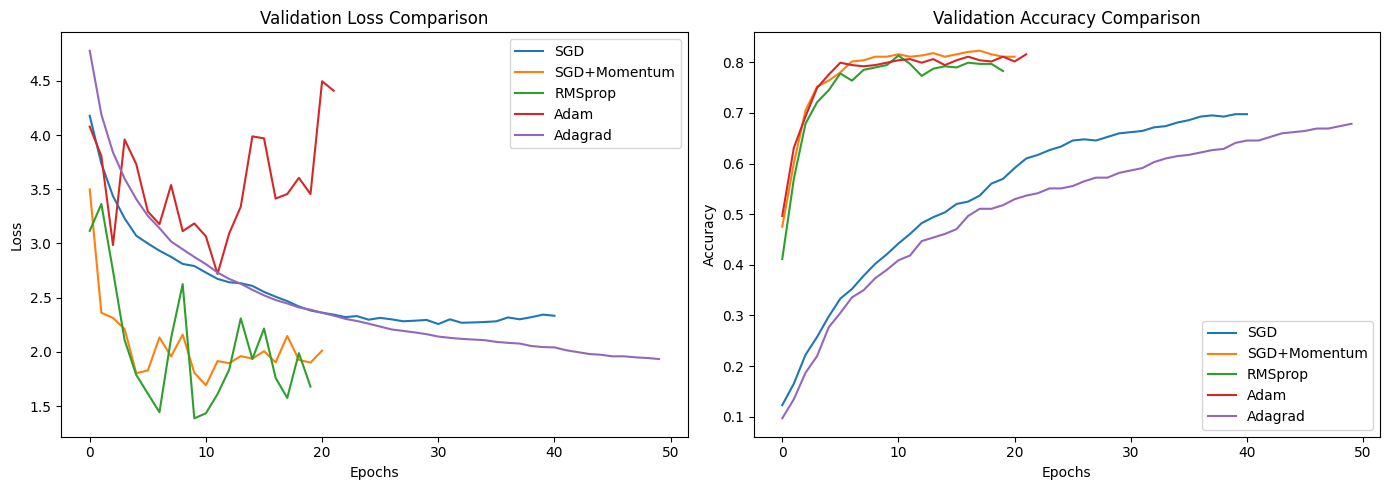

In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Builder
def build_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Optimizers
optimizers = {
    'SGD': SGD(learning_rate=0.001),
    'SGD+Momentum': SGD(learning_rate=0.001, momentum=0.9),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adam': Adam(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.001),
}

results = []
histories = {}

# Early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Training loop
for name, optimizer in optimizers.items():
    print(f"\nTraining with {name} optimizer...")
    model = build_model()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=50,
                        batch_size=8,
                        callbacks=[early_stop],
                        verbose=0)

    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    results.append({
        "Optimizer": name,
        "Train Loss": round(train_loss, 4),
        "Train Acc": round(train_acc * 100, 4),
        "Test Loss": round(test_loss, 4),
        "Test Acc": round(test_acc * 100, 2)
    })

    histories[name] = history

# Results table
df_results = pd.DataFrame(results)
print("\n=== Optimizer Comparison ===")
print(df_results)

# Plot loss and accuracy
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=name)
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=name)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(985, 3000)
(423, 3000)
(985, 16)
(423, 16)


In [42]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

In [50]:
input_neurons = X_train.shape[1]  # 3000 features
hidden_neurons = 16  # Hidden layer with 16 neurons
output_neurons = y_train.shape[1]  # Number of categories (output neurons)

# Initialize Weights and Biases with smaller initialization scale
np.random.seed(42)
W1 = np.random.randn(input_neurons, hidden_neurons) * 0.01
b1 = np.zeros((1, hidden_neurons))
W2 = np.random.randn(hidden_neurons, output_neurons) * 0.01
b2 = np.zeros((1, output_neurons))

# Training Parameters
learning_rate = 0.001  # Reduced learning rate for stability
epochs = 5000
losses = []
accuracies = []

# Gradient clipping max norm
max_grad_norm = 5.0

# Training Loop
for epoch in range(epochs):
    # 1. Forward Propagation
    hidden_input = np.dot(X_train, W1) + b1
    hidden_output = sigmoid(hidden_input)

    final_input = np.dot(hidden_output, W2) + b2
    final_output = sigmoid(final_input)

    # Clip the output to avoid log(0) errors
    final_output = np.clip(final_output, epsilon, 1 - epsilon)

    # 2. Compute Loss (Binary Cross-Entropy)
    loss = -np.mean(y_train * np.log(final_output) + (1 - y_train) * np.log(1 - final_output))
    losses.append(loss)

    # 3. Backpropagation
    error_output = final_output - y_train
    d_output = error_output * sigmoid_derivative(final_output)

    error_hidden = d_output.dot(W2.T)
    d_hidden = error_hidden * sigmoid_derivative(hidden_output)

    # Apply gradient clipping to avoid exploding gradients
    d_output = np.clip(d_output, -max_grad_norm, max_grad_norm)
    d_hidden = np.clip(d_hidden, -max_grad_norm, max_grad_norm)

    # 4. Update Weights and Biases
    W2 -= hidden_output.T.dot(d_output) * learning_rate
    b2 -= np.sum(d_output, axis=0, keepdims=True) * learning_rate
    W1 -= X_train.T.dot(d_hidden) * learning_rate
    b1 -= np.sum(d_hidden, axis=0, keepdims=True) * learning_rate

    # Print loss and accuracy every 500 epochs
    if epoch % 500 == 0:
        # Training accuracy
        predictions = (final_output > 0.5).astype(int)
        accuracy = np.mean(predictions == y_train) * 100
        accuracies.append(accuracy)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Training Accuracy: {accuracy:.2f}%")



Epoch 0, Loss: 0.6969, Training Accuracy: 34.58%
Epoch 500, Loss: 0.0687, Training Accuracy: 99.47%
Epoch 1000, Loss: 0.0360, Training Accuracy: 99.84%
Epoch 1500, Loss: 0.0290, Training Accuracy: 99.84%
Epoch 2000, Loss: 0.0255, Training Accuracy: 99.84%
Epoch 2500, Loss: 0.0230, Training Accuracy: 99.84%
Epoch 3000, Loss: 0.0211, Training Accuracy: 99.84%
Epoch 3500, Loss: 0.0194, Training Accuracy: 99.84%
Epoch 4000, Loss: 0.0179, Training Accuracy: 99.84%
Epoch 4500, Loss: 0.0166, Training Accuracy: 99.84%


In [51]:
# 5. Model Evaluation
hidden_input_test = np.dot(X_test, W1) + b1
hidden_output_test = sigmoid(hidden_input_test)

final_input_test = np.dot(hidden_output_test, W2) + b2
final_output_test = sigmoid(final_input_test)

# Clip the output to avoid log(0) errors during evaluation
final_output_test = np.clip(final_output_test, epsilon, 1 - epsilon)

predictions = (final_output_test > 0.5).astype(int)
accuracy = np.mean(predictions == y_test) * 100



Test Accuracy: 98.20%


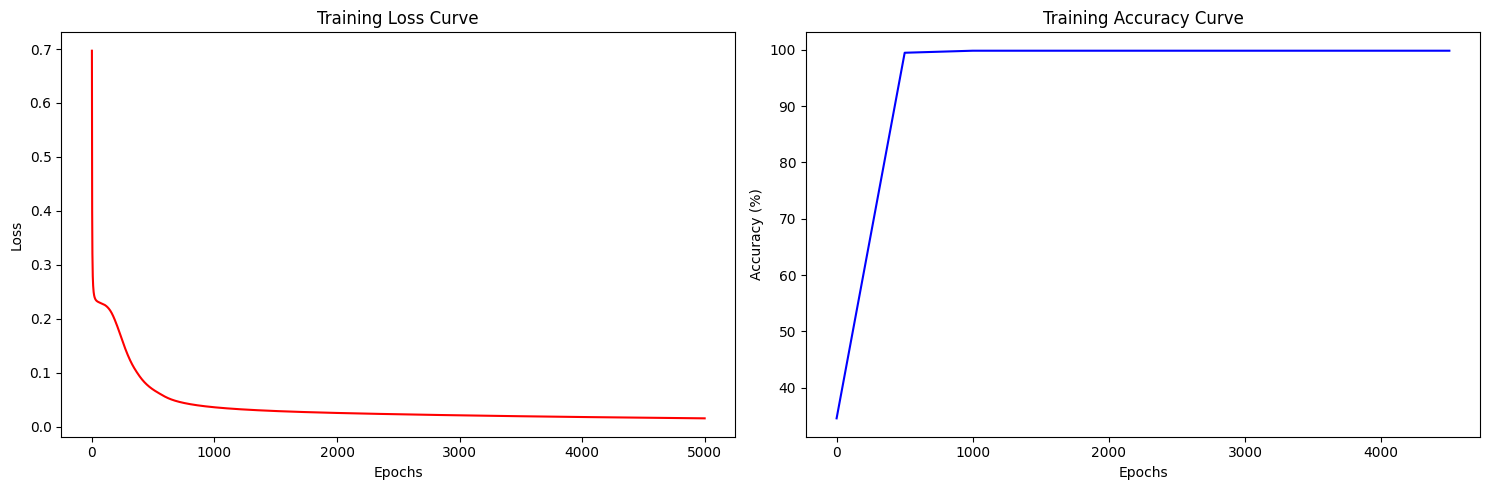

In [53]:
# 1. Print Test Accuracy
print(f"\nTest Accuracy: {accuracy:.2f}%")

# 2. Plot Loss and Accuracy Curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Loss Curve
ax1.plot(losses, label='Loss', color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve')

# Accuracy Curve
ax2.plot(range(0, epochs, 500), accuracies, label='Accuracy', color='blue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy Curve')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


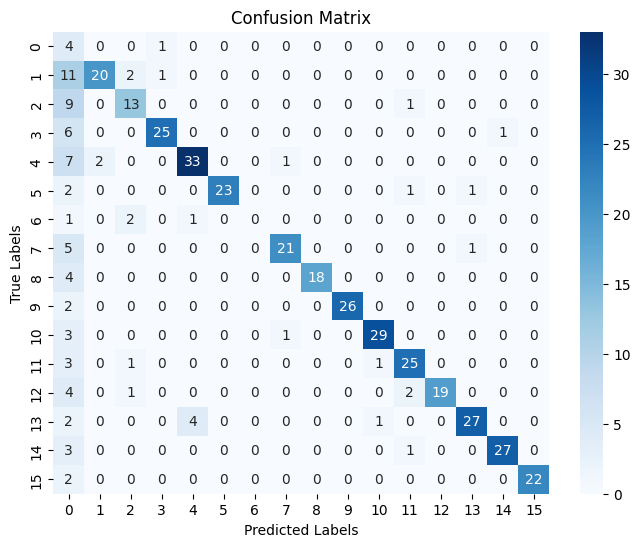

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the trained weights W1, W2, b1, b2 from your ANN training

# 1. Model Evaluation on Test Set
hidden_input_test = np.dot(X_test, W1) + b1
hidden_output_test = sigmoid(hidden_input_test)

final_input_test = np.dot(hidden_output_test, W2) + b2
final_output_test = sigmoid(final_input_test)

# Clip the output to avoid log(0) errors during evaluation
final_output_test = np.clip(final_output_test, epsilon, 1 - epsilon)

# 2. Convert the outputs to predicted labels (0 or 1)
predictions = (final_output_test > 0.5).astype(int)

# 3. Convert one-hot encoded labels to label indices for comparison
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded to label indices
predictions_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded to label indices

# 4. Compute confusion matrix
cm = confusion_matrix(y_test_labels, predictions_labels)

# 5. Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=one_hot_encoder.categories_[0], yticklabels=one_hot_encoder.categories_[0])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6. Calculate and Print Test Accuracy
accuracy = np.mean(predictions_labels == y_test_labels) * 100
